In [2]:
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from itertools import product

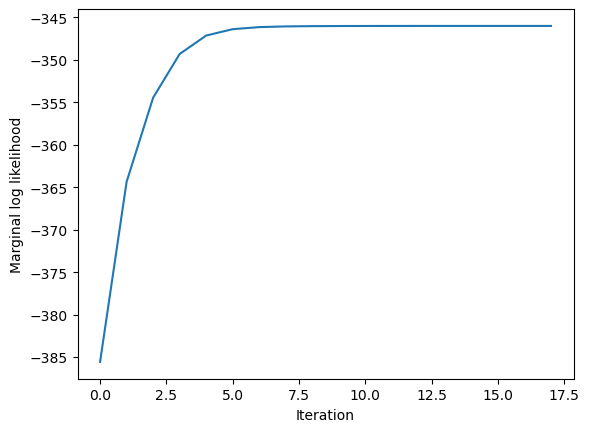

Estimated pi: [0.33034675 0.66965325]
Estimated w: [ 1.08132161 -2.04086311]
Estimated b: [-0.54369312  0.53055112]
Estimated sigma: [0.32155142 0.36773763]


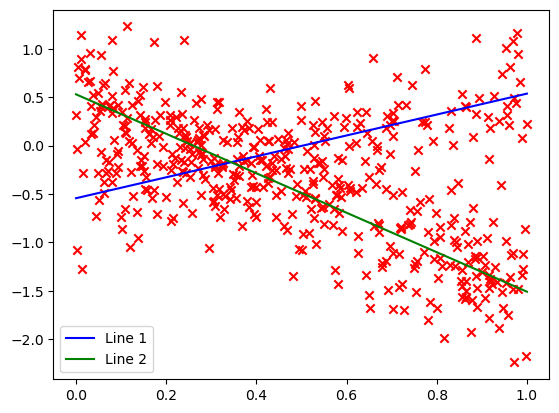

In [27]:
# Generate the data according to specification
# Implement EM Algorithm
N = 500
x = np.random.rand(N)
pi0 = np.array([0.7, 0.3])
w0 = np.array([-2, 1])
b0 = np.array([0.5, -0.5])
sigma0 = np.array([.4, .3])

y = np.zeros_like(x)
for i in range(N):
    k = 0 if np.random.rand() < pi0[0] else 1
    y[i] = w0[k]*x[i] + b0[k] + np.random.randn()*sigma0[k]
    
def m_step(z):
        pi_new = z.mean(axis = 0)
        w_new = np.zeros(2)
        b_new = np.zeros(2)
        var_new = np.zeros(2)
        x_hat = np.column_stack((x, np.ones(N)))

        for ki in range(2):
            zi = z[:, ki]
            wval = (np.linalg.inv(x_hat.T @ np.diag(zi) @ x_hat) @ (x_hat.T @ np.diag(zi) @ y))
            w_new[ki] = wval[0]
            b_new[ki] = wval[1]
            var_new[ki] = np.sum(zi * (y - x * w_new[ki] - b_new[ki])**2) / np.sum(zi)

        return pi_new, w_new, b_new, np.sqrt(var_new)

    
def em_algorithm(N, x, pi, w, b, sigma, y, iterations):
    log_iterations = []


    for i in range(iterations):
        z = np.zeros((N, 2))
        for ki in range(2):
            z[:, ki] = pi[ki] * norm.pdf(y, loc = np.dot(w[ki], x) + b[ki], scale=sigma[ki])
        z = z/np.sum(z, axis = 1, keepdims = True)
        pi, w, b, sigma = m_step(z)
        log_l = 0
        for j in range(N):
            likelihood_i = 0
            for ki in range(2):
                likelihood_i += pi[ki] * norm.pdf(y[j], loc=w[ki]*x[j]+b[ki], scale=sigma[ki])
            log_l += np.log(likelihood_i)
        log_iterations.append(log_l)
        if((i != 0) and (np.abs(log_iterations[-1] - log_iterations[-2]) < 1e-4)):
            break

    return np.asarray(log_iterations), pi, w, b, sigma



pi = np.array([0.5, 0.5])
w = np.array([1, -1])
b = np.array([0, 0])
sigma = np.array([np.std(y), np.std(y)])

log_ls, pi, w, b, sigma = em_algorithm(N, x, pi, w, b, sigma, y, 100)
plt.plot(log_ls)
plt.xlabel('Iteration')
plt.ylabel('Marginal log likelihood')
plt.show()

print("Estimated pi:", pi)
print("Estimated w:", w)
print("Estimated b:", b)
print("Estimated sigma:", sigma)

plt.scatter(x, y, c='r', marker='x')
x_line = np.linspace(0, 1, 100)
plt.plot(x_line, w[0]*x_line + b[0], label='Line 1', color = 'blue')
plt.plot(x_line, w[1]*x_line + b[1], label='Line 2', color = 'green')
plt.legend()
plt.show()

In [45]:
# Given Observed Sequence, Compute Posterior Distribution (Report 3 Most Likely Sequences)
A = np.array([[0.5, 0.2, 0.3], [0.2, 0.4, 0.4], [0.4, 0.1, 0.5]])
phi = np.array([[0.8, 0.2], [0.1, 0.9], [0.5, 0.5]])
pi0 = np.array([0.5, 0.3, 0.2])

obs_seq = [0, 1, 0, 1]

T = len(obs_seq)
N = len(A)
alpha = np.zeros((T, N))

alpha[0] = pi0 * phi[:, obs_seq[0]]

for t in range(1, T):
    alpha[t] = np.dot(alpha[t - 1], A) * phi[:, obs_seq[t]]

beta[-1] = 1

for t in range(T - 2, -1, -1):
    beta[t] = np.dot(A, (phi[:, obs_seq[t + 1]] * beta[t + 1]))
    
obs_prob = np.sum(alpha[-1])

state_space = list(product(range(3), repeat=len(obs_seq)))
posterior_probs = []

for state_seq in state_space:
    prior_prob = pi0[state_seq[0]] * np.prod([A[state_seq[i], state_seq[i + 1]] for i in range(len(state_seq) - 1)])
    likelihood = np.prod([phi[state_seq[i], obs_seq[i]] for i in range(len(state_seq))])
    posterior_prob = (prior_prob * likelihood) / obs_prob
    posterior_probs.append(posterior_prob)

top_3_indices = np.argsort(posterior_probs)[-3:][::-1]
top_3_state_seqs = [state_space[i] for i in top_3_indices]

for i in top_3_indices:
    state_seq = state_space[i]
    prior_prob = pi0[state_seq[0]] * np.prod([A[state_seq[i], state_seq[i + 1]] for i in range(len(state_seq) - 1)])
    likelihood = np.prod([phi[state_seq[i], obs_seq[i]] for i in range(len(state_seq))])
    posterior_prob = posterior_probs[i]
    print(f"State: {state_seq} Prior: {prior_prob:.6f} Likelihood: {likelihood:.6f} Posterior: {posterior_prob:.6f}")

State: (0, 2, 2, 2) Prior: 0.037500 Likelihood: 0.100000 Posterior: 0.073522
State: (0, 1, 2, 2) Prior: 0.020000 Likelihood: 0.180000 Posterior: 0.070581
State: (0, 2, 0, 1) Prior: 0.012000 Likelihood: 0.288000 Posterior: 0.067758


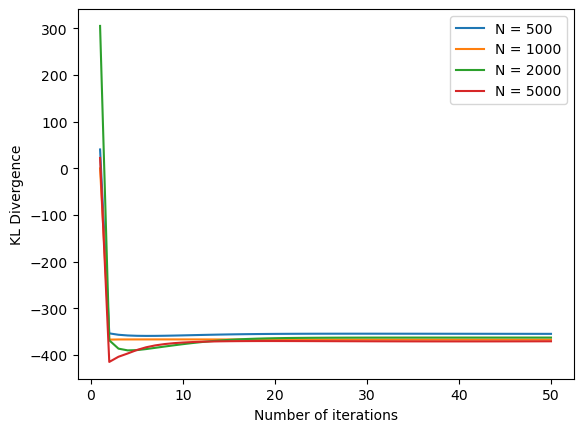

In [3]:
# Learn HMM Parameters by Baum-Welch
# Run EM Algorithm
def forward(obs_seq, A, phi, pi0):
    T = len(obs_seq)
    N = len(A)
    alpha = np.zeros((T, N))

    alpha[0] = pi0 * phi[:, obs_seq[0]]

    for t in range(1, T):
        alpha[t] = np.dot(alpha[t - 1], A) * phi[:, obs_seq[t]]

    return alpha

def backward(obs_seq, A, phi):
    T = len(obs_seq)
    N = len(A)
    beta = np.zeros((T, N))

    beta[-1] = 1

    for t in range(T - 2, -1, -1):
        beta[t] = np.dot(A, (phi[:, obs_seq[t + 1]] * beta[t + 1]))

    return beta

def baum_welch(obs_seqs, A, phi, pi0, n_iterations=50):
    N = len(A)
    M = len(phi[0])

    for _ in range(n_iterations):
        xi_sum = np.zeros((N, N))
        gamma_sum = np.zeros(N)
        gamma_x_sum = np.zeros((N, M))
        pi0_sum = np.zeros(N)
        for obs_seq in obs_seqs:
            alpha = forward(obs_seq, A, phi, pi0)
            beta = backward(obs_seq, A, phi)
            prob = np.sum(alpha[-1])
            gamma = alpha * beta / prob
            xi = np.zeros((len(obs_seq) - 1, N, N))
            for t in range(len(obs_seq) - 1):
                xi[t] = alpha[t][:, np.newaxis] * A * phi[:, obs_seq[t + 1]] * beta[t + 1]
            xi = xi / prob
            xi_sum += np.sum(xi, axis=0)
            gamma_sum += np.sum(gamma[:-1], axis=0)
            
            for i in range(N):
                gamma_x_sum[i] += np.bincount(obs_seq, weights=gamma[:, i], minlength=M)
            pi0_sum += gamma[0]

        A = xi_sum / gamma_sum[:, np.newaxis]
        phi = gamma_x_sum / gamma_sum[:, np.newaxis]
        pi0 = pi0_sum / len(obs_seqs)

    return A, phi, pi0

def kl_divergence(p, q):
    return np.sum(p * np.log(p / q))




# Generate the HMM data 

A_true = np.array([[0.5, 0.2, 0.3], [0.2, 0.4, 0.4], [0.4, 0.1, 0.5]])
phi_true = np.array([[0.8, 0.2], [0.1, 0.9], [0.5, 0.5]])
pi0_true = np.array([0.5, 0.3, 0.2])

X = []

for _ in range(5000):
    z = [np.random.choice([0,1,2], p=pi0_true)]
    for _ in range(3):
        z.append(np.random.choice([0,1,2], p=A_true[z[-1]]))
    x = [np.random.choice([0,1], p=phi_true[zi]) for zi in z]
    X.append(x)


N_values = [500, 1000, 2000, 5000]
n_iterations = 50
kl_values = []

for N in N_values:
    train_data = X[:N]
    A_init = np.random.dirichlet(np.ones(3), size=3)
    phi_init = np.random.dirichlet(np.ones(2), size=3)
    pi0_init = np.random.dirichlet(np.ones(3))
    kl_iter = []
    for i in range(n_iterations):
        A_est, phi_est, pi0_est = baum_welch(train_data, A_init, phi_init, pi0_init, n_iterations=i)
        p_true = np.array([np.sum(forward(seq, A_true, phi_true, pi0_true)[-1]) for seq in X])
        p_est = np.array([np.sum(forward(seq, A_est, phi_est, pi0_est)[-1]) for seq in X])
        kl_iter.append(kl_divergence(p_true, p_est))

    kl_values.append(kl_iter)

for i, N in enumerate(N_values):
    plt.plot(range(1, n_iterations + 1), kl_values[i], label=f"N = {N}")

plt.xlabel("Number of iterations")
plt.ylabel("KL Divergence")
plt.legend()
plt.show()